# Automatic Noise Detection for Ambulatory Electrocardiogram in Presence of Ventricular Arrhythmias Through a Machine Learning Approach

This notebook replicates the study illustrated in the omonimous paper _“Automatic noise detection for ambulatory electrocardiogram in presence of ventricular arrhythmias through a machine learning approach” (L. Bachi et al., 2024, [DOI](https://doi.org/10.1016/j.compbiomed.2024.109288))_, which originally was conducted in MATLAB. The database used in this notebook is slightly larger than the original version described in the paper, due to a few records of supraventricular tachycardia added in database C. The database is composed of noise indices (also referred to as noise _indexes_), _i.e._ different measures of the amount of noise that is affecting ECG at a given time point. Noise indices were computed on annotated 2-seconds long single-lead ECG windows. Here is an example of normal ECG, ventricular arrhythmia, and noise:

![Normal ECG, ventricular tachycardia, noise side-by-side examples](signal_examples_Github2.png "Title")

The feature-based database is also different from what was shown in [the original publication](https://doi.org/10.1016/j.compbiomed.2024.109288). This version includes a higher number of features, which can be grouped in two:
- Inv-based features. In the paper, the *inv* feature was defined as signal slope inversions tied to amplitude variation over a minimum threshold set to 100 microvolts. However, the value of this tresholds was chosen arbitrarily. This version of the feature database includes a number of *inv* features computed using different thresholds values rangin from 50 microvolts (*inv50*) to 275 microvolts (*inv275*). In this notebook the most useful *inv* features for this task will be determined.
- Edp-based features. The "ECG derivative pattern index" (*edp*) was computed by combining different parameters computed as a trimmed mean of the maxima of the signal's derivative in different window lengths, using two derivative filters ([-1, 0, 1] and [-1, 1]). The feature dataset in this notebook includes additional parameters: *maaa* is the signal's maximum absolute amplitude on the whole 2s window; *maaf* is the average of the signal's maximum absolute amplitude on 0.66s windows; *maan* is the average of the signal's maximum absolute amplitude on 0.066s windows; *mDfa* is the maximum absolute derivative (computed using the [-1, 0, 1] filter) on the whole 2s window; *mDf* is the average of the maximum absolute derivative ([-1, 0, 1] filter) on 0.66s windows; *mDn* is the average of the maximum absolute derivative ([-1, 0, 1] filter) on 0.066s windows; *mDhn* is the average of the maximum absolute derivative (computed with a different filter, [-1, 1] ) on 0.066s windows. Additionally: $$\textit{edp} = \frac{\text{mDf}}{\text{mDn}}$$ $$\textit{edpc0} = \frac{\text{mDf} - 3 \text{mDn} - \text{mDhn} - 0.2 \text{mDfa}}{mDf + 3 \text{mDn} + \text{mDhn} + 0.2 \text{mDfa}}$$ $$edpc = \frac{\text{mDf} - 3 \text{mDn} - \text{mDhn} - 0.2 \text{mDfa}}{\text{mDf} + 3 \text{mDn} + \text{mDhn} + 0.2 \text{mDfa}} + 0.7 \frac{\text{mmaf} - \text{maan} - \text{maaa}}{\text{maaf} + \text{maan} + \text{maan}}$$

The other features in this database are relative power in the QRS complex (*rpow*), relative power in the baseline (*bas*), kurtosis (*kur*), skewness (*skew*), signal-to-noise ratio (*snr*), and high order statistic (*hos*).


As the part of the original ECG database is private, this notebook will only feature script outputs. The database will not be shared.

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, matthews_corrcoef
import joblib #saving best models
import matplotlib.pyplot as plt
import inspect # checking which model accepts sample_weights
from sklearn.pipeline import Pipeline #for model-agnositc training function
from sklearn.preprocessing import StandardScaler #non-tree models may need feature scaling
import seaborn as sns #visualizing boxplots
from sklearn.inspection import permutation_importance
import os #for cpu count

from noiseIdxDB_utils import load_noiseIdxDB_features, compute_noiseIdxDB_sample_weights, get_performance_metrics

Reading the noiseIdxDB_features database:

In [3]:
X, y, a, featureNames, labelNames, subject_ids = load_noiseIdxDB_features()

Noise index database: 163896 samples, 27 features 
Shape of main outcome y: (163896,)


In [4]:
print(featureNames)

['inv50', 'inv75', 'inv100', 'inv125', 'inv150', 'inv175', 'inv200', 'inv225', 'inv250', 'inv275', 'area', 'rpow', 'bas', 'skew', 'kur', 'snr', 'hos', 'maaa', 'maaf', 'maan', 'mDfa', 'mDf', 'mDn', 'mDhn', 'edp', 'edpc0', 'edpc']


Setting up sample weights so that records of arrhythmia have higher misclassification cost:

In [11]:
sample_weights = compute_noiseIdxDB_sample_weights(a, y)

Normal ECG records: 111353, weight = 1
Noise records: 33721, weight = 3.3021855816850034
Records of ECG with ventricular arrhythmias: 10768, weight = 10.341103268945023
Records of ECG with supraventricular tachycardias: 8054, weight = 13.825800844300968


Setting up cross validation:

In [4]:
# nested cross-validation where inner folds are used for hyperparameter tuning
# outer folds are used to estimate generalization performance
# grouped cross-validation is used to ensure that all samples from the same subject are in the same fold, to avoid data leakage
nof = 5  # number of outer folds
outer_cv = GroupKFold(n_splits=nof)
inner_cv = GroupKFold(n_splits=3)

Training decision trees (DTs):

In [ ]:
# define the model and hyperparameter grid
param_grid = {
    'max_leaf_nodes' : [20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2']
}

# set up the grid search with inner cross-validation. No limit on number of jobs to use all available CPUs
grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=0),
    param_grid=param_grid,
    scoring=make_scorer(matthews_corrcoef), # use Matthews correlation coefficient as scoring metric
    cv=inner_cv,
    refit=True,
    n_jobs=-1
)

# metrics of interest: MCC, sensitivity, specificity, specificity on records of ECG with ventricular arrhythmias (critical records)
outer_MCC = []
outer_sens = []
outer_spec = []
outer_spec_v = []
models = []
# save also the best hyperparameters per fold
params = []

# outer cross-validation loop
fold_idx = 0
print("Training a decision tree with nested cross validation ...")
for train_idx, test_idx in outer_cv.split(X, y, groups=subject_ids):
    
    fold_idx = fold_idx+1
    print("Outer fold " + str(fold_idx) + " ...")
    grid.fit(X[train_idx], y[train_idx], sample_weight=w[train_idx], groups = subject_ids[train_idx])

    y_test = y[test_idx]
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X[test_idx])
    params.append(grid.best_params_)

    # get performance metrics: MCC, sensitivity, specificity, specificity on records of ECG with ventricular arrhythmias
    a_test = a[test_idx]
    MCC, sens, spec, spec_v = get_performance_metrics(y_test, y_pred, a_test)
    outer_MCC.append(MCC)
    outer_sens.append(sens)
    outer_spec.append(spec)
    outer_spec_v.append(spec_v)
    
    # save the model
    # joblib.dump(best_model, f"best_dectree_fold{fold_idx}.joblib")
    # joblib.dump(test_idx, f"test_idx_fold{fold_idx}.joblib")
    models.append(best_model)

print("Outer CV MCC scores:", outer_MCC)
print("Mean outer MCC:", np.mean(outer_MCC))
print("Mean outer CV sensibility:", np.mean(outer_sens))
print("Mean outer CV specificity:", np.mean(outer_spec))
print("Mean outer CV specificity on records of ECG with ventricular arrhythmias:", np.mean(outer_spec_v))

# save results
results = {
    "mcc": outer_MCC,
    "sens": outer_sens,
    "spec": outer_spec,
    "spec_v": outer_spec_v
}

joblib.dump((results, params, models), "results_dt.joblib")

Training a decision tree with nested cross validation ...
Outer fold 1 ...
Outer fold 2 ...
Outer fold 3 ...
Outer fold 4 ...
Outer fold 5 ...
Outer CV MCC scores: [0.7061403424863065, 0.7701285702853824, 0.7656743088250028, 0.841569373527426, 0.8523475624289376]
Mean outer MCC: 0.7871720315106111
Mean outer CV sensibility: 0.810830319349941
Mean outer CV specificity: 0.9646000404264194
Mean outer CV specificity on records of ECG with ventricular arrhythmias: 0.9157824539647252


['results_dt.joblib']

Training other sample models: logistic regression (DT), k-nearest neighbor (kNN), support vector machine (SVM), random forest (RF), XGBoost (XB)

In [ ]:
# model-agnostic training function
def nested_cv_model(X, y, subject_ids, weights, pipeline, param_grid, outer_cv, inner_cv):
    # performance metrics: matthews correlation coefficient, sensitivity, specificity,
    # specificity on records of ECG with ventricular arrhythmias
    outer_MCC = []
    outer_sens = []
    outer_spec =[]
    outer_spec_v = []
    #collect best models and parameters
    best_params = []
    best_models = []

    # check if the pipeline's final estimator supports sample weights
    use_weights = "sample_weight" in inspect.signature(pipeline.steps[-1][1].fit).parameters

    fold_idx = 0
    for train_idx, test_idx in outer_cv.split(X, y, groups=subject_ids):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        w_train = weights[train_idx]
        # avoid data leakage by grouping samples from the same subject
        groups_train = subject_ids[train_idx]

        fold_idx = fold_idx+1
        print("Outer fold " + str(fold_idx) + " ...")

        grid = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            scoring=make_scorer(matthews_corrcoef),
            cv=inner_cv,
            n_jobs=-1,
            refit=True
        )

        # model training
        fit_params = {"groups": groups_train}
        if use_weights:
            fit_params["classifier__sample_weight"] = w_train
        grid.fit(X_train, y_train, **fit_params)

        # evaluate on outer test set
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)

        best_params.append(grid.best_params_)
        best_models.append(best_model)

        # compute metrics
        a_test = a[test_idx]
        MCC, sens, spec, spec_v = get_performance_metrics(y_test, y_pred, a_test)
        outer_MCC.append(MCC)
        outer_sens.append(sens)
        outer_spec.append(spec)
        outer_spec_v.append(spec_v)

    results = {
        "mcc": outer_MCC,
        "sens": outer_sens,
        "spec": outer_spec,
        "spec_v": outer_spec_v
    }

    return results, best_params, best_models

Logistic regression:

In [ ]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(
        solver="saga",
        # les than 1000 iterations are insufficient for elastic net convergence
        max_iter=2000,
        # tolerance facilitates reasonable convergence
        tol = 1e-3,
        random_state=0
    ))
])

param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10],
    "classifier__l1_ratio": [0, 0.5, 1]
}

results, params, models = nested_cv_model(
    X, y, subject_ids, w,
    pipe, param_grid,
    outer_cv, inner_cv
)
print("Logistic regression results:")
print("Mean outer MCC:", np.mean(results["mcc"]))
print("Mean outer CV sensibility:", np.mean(results["sens"]))
print("Mean outer CV specificity:", np.mean(results["spec"]))
print("Mean outer CV specificity on records of ECG with ventricular arrhythmias:", np.mean(results["spec_v"]))
joblib.dump((results, params, models), "results_lr.joblib")

Outer fold 1 ...
Outer fold 2 ...
Outer fold 3 ...
Outer fold 4 ...
Outer fold 5 ...
Logistic regression results:
Mean outer MCC: 0.7560937202514034
Mean outer CV sensibility: 0.7072394854406002
Mean outer CV specificity: 0.9818119779401233
Mean outer CV specificity on records of ECG with ventricular arrhythmias: 0.9203745889540855


['results_lr.joblib']

k-nearest neighbors(kNN):

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", KNeighborsClassifier())
])

param_grid = {
    "classifier__n_neighbors": [5, 10, 20, 50],
    "classifier__weights": ["uniform", "distance"],
    "classifier__p": [1, 2]   # Manhattan vs Euclidean
}

results, params, models = nested_cv_model(
    X, y, subject_ids, w,
    pipe, param_grid,
    outer_cv, inner_cv
)

print("k-nearest neighbors results:")
print("Mean outer MCC:", np.mean(results["mcc"]))
print("Mean outer CV sensibility:", np.mean(results["sens"]))
print("Mean outer CV specificity:", np.mean(results["spec"]))
print("Mean outer CV specificity on records of ECG with ventricular arrhythmias:", np.mean(results["spec_v"]))
joblib.dump((results, params, models), "results_knn.joblib")

Outer fold 1 ...
Outer fold 2 ...
Outer fold 3 ...
Outer fold 4 ...
Outer fold 5 ...
k-nearest neighbors results:
Mean outer MCC: 0.8701356315922691
Mean outer CV sensibility: 0.8885442163461874
Mean outer CV specificity: 0.9770990374443456
Mean outer CV specificity on records of ECG with ventricular arrhythmias: 0.910544815664361


['results_knn.joblib']

Support vector machine:

In [ ]:
from sklearn.svm import SVC

pipe = Pipeline([
    ("scaler", StandardScaler()),
    # RBF kernel the most accurate non linear SVM
    ("classifier", SVC(kernel="rbf", probability=False))
])

param_grid = {
    "classifier__C": [0.1, 1, 10],
    "classifier__gamma": ["scale", 0.01, 0.1]
}

results, params, models = nested_cv_model(
    X, y, subject_ids, w,
    pipe, param_grid,
    outer_cv, inner_cv
)

print("Support vector machine results:")
print("Mean outer MCC:", np.mean(results["mcc"]))
print("Mean outer CV sensibility:", np.mean(results["sens"]))
print("Mean outer CV specificity:", np.mean(results["spec"]))
print("Mean outer CV specificity on records of ECG with ventricular arrhythmias:", np.mean(results["spec_v"]))
joblib.dump((results, params, models), "results_svm.joblib")

Outer fold 1 ...
Outer fold 2 ...
Outer fold 3 ...
Outer fold 4 ...
Outer fold 5 ...
Support vector machine results:
Mean outer MCC: 0.8898121993579832
Mean outer CV sensibility: 0.9322455767439033
Mean outer CV specificity: 0.9728076375658621
Mean outer CV specificity on records of ECG with ventricular arrhythmias: 0.9505975770607862


['results_svm.joblib']

Random forest (RF):

In [ ]:
from sklearn.ensemble  import RandomForestClassifier

pipe = Pipeline([
    ("classifier", RandomForestClassifier(
        # number of trees not optimized as 100 are sufficient given dataset size
        n_estimators=100,
        random_state=0,
        n_jobs=-1
    ))
])

param_grid = {
    "classifier__max_depth": [None, 5, 10, 15],
    "classifier__min_samples_leaf": [1, 5, 10],
    "classifier__max_features": ["sqrt", "log2"]
}

results, params, models = nested_cv_model(
    X, y, subject_ids, w,
    pipe, param_grid,
    outer_cv, inner_cv
)
print("Random forest results:")
print("Mean outer MCC:", np.mean(results["mcc"]))
print("Mean outer CV sensibility:", np.mean(results["sens"]))
print("Mean outer CV specificity:", np.mean(results["spec"]))
print("Mean outer CV specificity on records of ECG with ventricular arrhythmias:", np.mean(results["spec_v"]))
joblib.dump((results, params, models), "results_rf.joblib")

Outer fold 1 ...
Outer fold 2 ...
Outer fold 3 ...
Outer fold 4 ...
Outer fold 5 ...
Random forest results:
Mean outer MCC: 0.884247584989755
Mean outer CV sensibility: 0.8956485933558624
Mean outer CV specificity: 0.9801420138521774
Mean outer CV specificity on records of ECG with ventricular arrhythmias: 0.9390005343518435


['results_rf.joblib']

XGBoost (XB):

In [19]:
from xgboost import XGBClassifier

pipe = Pipeline([
    ("classifier", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_estimators=100,
        n_jobs=-1,
        random_state=0
    ))
])

param_grid = {
    "classifier__max_depth": [3, 5, 7],
    "classifier__learning_rate": [0.01, 0.1],
    "classifier__subsample": [0.8, 1.0],
    "classifier__colsample_bytree": [0.8, 1.0]
}

results, params, models = nested_cv_model(
    X, y, subject_ids, w,
    pipe, param_grid,
    outer_cv, inner_cv
)
print("XGBoost results:")
print("Mean outer MCC:", np.mean(results["mcc"]))
print("Mean outer CV sensibility:", np.mean(results["sens"]))
print("Mean outer CV specificity:", np.mean(results["spec"]))
print("Mean outer CV specificity on records of ECG with ventricular arrhythmias:", np.mean(results["spec_v"]))
joblib.dump((results, params, models), "results_xb.joblib")

Outer fold 1 ...
Outer fold 2 ...
Outer fold 3 ...
Outer fold 4 ...
Outer fold 5 ...
XGBoost results:
Mean outer MCC: 0.8922504159799262
Mean outer CV sensibility: 0.9318598736009172
Mean outer CV specificity: 0.9737904392219529
Mean outer CV specificity on records of ECG with ventricular arrhythmias: 0.9470237962124619


['results_xb.joblib']

# Results

Performance table

In [ ]:
rows = []

model_names = ["DT", "LR", "kNN", "SVM", "RF", "XB"]
metric_names = ["MCC", "Se", "Sp", "SpV"]

for model_idx in range(len(model_names)):
    
    results = joblib.load(f"results_{model_names[model_idx].lower()}.joblib")[0]
    for fold_idx in range(nof):
        row = {"model": model_names[model_idx], "fold": (fold_idx)}

        metric_idx = 0
        for key, value in results.items():
            row[metric_names[metric_idx]] = float(value[fold_idx])
            metric_idx = metric_idx + 1
        rows.append(row)

# results as a DataFrame
results_df = pd.DataFrame(rows)

summary = (results_df.groupby("model").agg(
        mcc_mean=(metric_names[0], "mean"),
        mcc_std=(metric_names[0], "std"),
        se_mean=(metric_names[1], "mean"),
        se_std=(metric_names[1], "std"),
        sp_mean=(metric_names[2], "mean"),
        sp_std=(metric_names[2], "std"),
        spv_mean=(metric_names[3], "mean"),
        spv_std=(metric_names[3], "std"),
    )
)
# reindex with the correct model order
print(summary.reindex(model_names).round(3))

       mcc_mean  mcc_std  se_mean  se_std  sp_mean  sp_std  spv_mean  spv_std
model                                                                        
DT        0.787    0.060    0.811   0.083    0.965   0.019     0.916    0.046
LR        0.756    0.051    0.707   0.079    0.982   0.011     0.920    0.028
kNN       0.870    0.046    0.889   0.050    0.977   0.013     0.911    0.064
SVM       0.890    0.039    0.932   0.041    0.973   0.014     0.951    0.049
RF        0.884    0.042    0.896   0.054    0.980   0.014     0.939    0.069
XB        0.892    0.037    0.932   0.040    0.974   0.014     0.947    0.062


Boxplots:

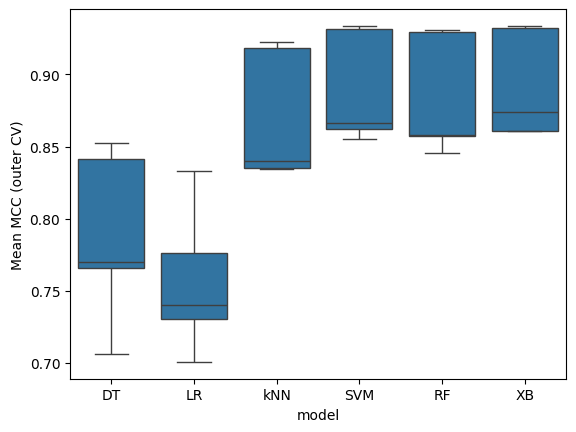

In [7]:
sns.boxplot(data=results_df, x="model", y="MCC")
plt.ylabel("Mean MCC (outer CV)")
plt.show()

Feature importance (with permutation on outer folds):

In [ ]:
import time

# avoid using kNN, takes too long to compute permutation importance
model_names = ["DT", "LR", "SVM", "RF", "XB"]
# fetch models from saved results
models = {}
for model_idx in range(len(model_names)):
    
    model_folds = joblib.load(f"results_{model_names[model_idx].lower()}.joblib")[2]
    classifiers = []
    #if isinstance(model_folds[0], Pipeline):
    #    for fold_idx in range(nof):
    #        classifiers.append(model_folds[fold_idx].named_steps['classifier'])
    #else:
    #    classifiers = model_folds
    classifiers = model_folds
    models[model_names[model_idx]] = classifiers

# load test sets
X_tests = []
y_tests = []
for train_idx, test_idx in outer_cv.split(X, y, groups=subject_ids):
    X_tests.append(X[test_idx])
    y_tests.append(y[test_idx])

# function to compute permutation importance for a single model
def compute_permutation_importance(
    models,
    X_tests,
    y_tests,
    feature_names,
    scoring="matthews_corrcoef",
    n_repeats=5,
    random_state=0,
    n_jobs=os.cpu_count()-2 # avoid using all cores
):
    """
    Compute permutation importance for all models and outer folds.

    Returns
    -------
    mean_df : pd.DataFrame
        Rows = features, columns = models (mean importance)
    std_df : pd.DataFrame
        Rows = features, columns = models (std across folds)
    """

    mean_importance = {}
    std_importance = {}

    n_folds = len(X_tests)

    for model_name, fold_models in models.items():
        fold_importances = []

        for fold_idx in range(n_folds):
            print(f"Computing permutation importance for {model_name}, fold {fold_idx}")
            model = fold_models[fold_idx]
            X_test = X_tests[fold_idx]
            y_test = y_tests[fold_idx]

            r = permutation_importance(
                model,
                X_test,
                y_test,
                scoring=scoring,
                n_repeats=n_repeats,
                random_state=random_state,
                n_jobs=n_jobs
            )

            fold_importances.append(r.importances_mean)

        fold_importances = np.vstack(fold_importances)

        mean_importance[model_name] = fold_importances.mean(axis=0)
        std_importance[model_name]  = fold_importances.std(axis=0)

    mean_df = pd.DataFrame(mean_importance, index=feature_names)
    std_df  = pd.DataFrame(std_importance, index=feature_names)

    return mean_df, std_df

# compute importance tables for all models
start = time.time()
mean_imp, std_imp = compute_permutation_importance(
    models=models,
    X_tests=X_tests,
    y_tests=y_tests,
    feature_names=featureNames,
    scoring="matthews_corrcoef"
)
print(f"Time taken for permutation importance: {time.time() - start} seconds")
joblib.dump(mean_imp,"mean_feature_importance.joblib")

Computing permutation importance for DT, fold 0
Computing permutation importance for DT, fold 1
Computing permutation importance for DT, fold 2
Computing permutation importance for DT, fold 3
Computing permutation importance for DT, fold 4
Computing permutation importance for LR, fold 0
Computing permutation importance for LR, fold 1
Computing permutation importance for LR, fold 2
Computing permutation importance for LR, fold 3
Computing permutation importance for LR, fold 4
Computing permutation importance for SVM, fold 0
Computing permutation importance for SVM, fold 1
Computing permutation importance for SVM, fold 2
Computing permutation importance for SVM, fold 3
Computing permutation importance for SVM, fold 4
Computing permutation importance for RF, fold 0
Computing permutation importance for RF, fold 1
Computing permutation importance for RF, fold 2
Computing permutation importance for RF, fold 3
Computing permutation importance for RF, fold 4
Computing permutation importance fo

['mean_feature_importance.joblib']

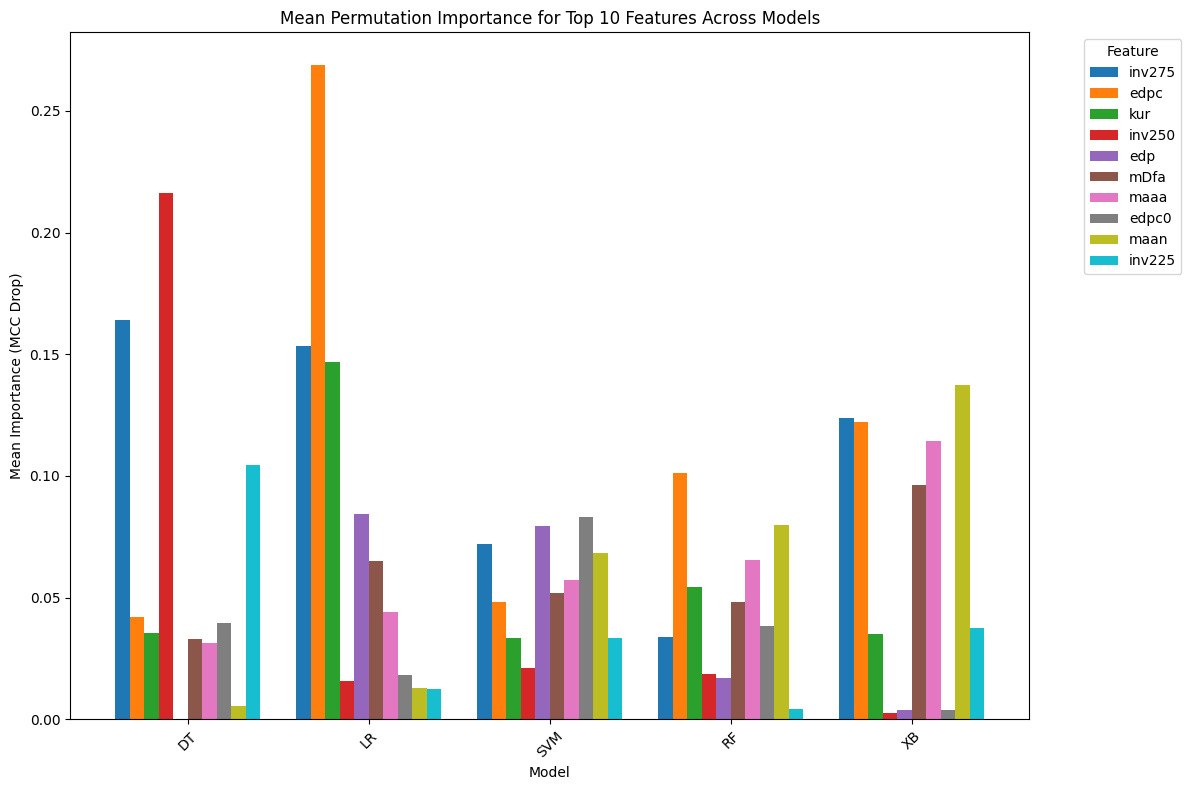

In [18]:
# number of top features
ntop = 10

joblib.load("mean_feature_importance.joblib")

# standardize feature importance
mean_imp_norm = mean_imp.div(mean_imp.abs().sum(axis=0), axis=1)  # Normalize per model (column)

# select top features based on mean importance across models
top_features = mean_imp.mean(axis=1).sort_values(ascending=False).head(ntop).index
mean_imp_top = mean_imp_norm.loc[top_features]

# Plot the top features' mean importances across models
mean_imp_top.T.plot(kind='bar', figsize=(12, 8), width=0.8)
plt.title('Mean Permutation Importance for Top ' + str(ntop) + ' Features Across Models')
plt.ylabel('Mean Importance (MCC Drop)')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

As expected, different models exploit the information content of different features. The DT favors the inv275/250 features, probably in different outer folds as they are highly correlated. LR is very reliant of 'edpc', a highly engineered feature which complements the somewhat simpler approach of LR. SVM, RF and XB on the other hand are able to exploit a wider range of features, notably 'maan', and 'maaa'. The SVM preferred 'edpc0' and 'edp', two simpler versions of 'edpc'.